In [2]:
import numpy as np
import pandas as pd
import sys
import os

from matplotlib import pyplot as plt

sys.path.append('../..')

from heat_load_calc import season
from heat_load_calc.weather import Weather
from heat_load_calc.interval import Interval

## seasonに実装する_get_season_status_by_fourier_tranformを外部から実行する

### weatherクラスの作成

In [3]:
# 気象データを作成
_d_common_ees = {
        "weather": {
            "method": "ees",
            "region": "6"
        }
    }

w=Weather.make_weather(d_common=_d_common_ees, itv=Interval.M15)

In [4]:
for i in range(1, 9):
    # 気象データを作成
    _d_common_ees = {
            "weather": {
                "method": "ees",
                "region": str(i)
            }
        }
    w=Weather.make_weather(d_common=_d_common_ees, itv=Interval.M15)
    print(i, season._get_season_status_by_fourier_tranform(w=w))

1 ('09/17', '06/07', '06/27', '08/24', True, True)
2 ('09/25', '06/05', '07/03', '08/24', True, True)
3 ('10/05', '05/21', '06/14', '09/07', True, True)
4 ('10/12', '05/13', '06/01', '09/18', True, True)
5 ('10/19', '05/06', '06/02', '09/23', True, True)
6 ('11/01', '04/24', '05/18', '10/05', True, True)
7 ('11/10', '04/12', '05/14', '10/14', True, True)
8 (None, None, '04/26', '11/13', False, True)


In [11]:
parent_absolute_path = os.path.dirname(os.path.dirname(os.path.abspath(path=os.path.curdir)))
temp_h = np.array(pd.read_csv(parent_absolute_path + "/test/module_test/weather_for_method_file.csv")['temperature'])
print(temp_h)

_d_common_file = {
    "weather": {
        "method": "file",
        "file_path": "weather_for_method_file.csv",
        "latitude": 26.21,
        "longitude": 127.685
    }
}

entry_point_dir = parent_absolute_path + "/test/module_test"

w = Weather.make_weather(d_common=_d_common_file, itv=Interval.M15, entry_point_dir=entry_point_dir)

print(w.theta_o_h)

[19.1 19.1 19.7 ... 19.2 18.9 19. ]
[19.1 19.1 19.7 ... 19.2 18.9 19. ]


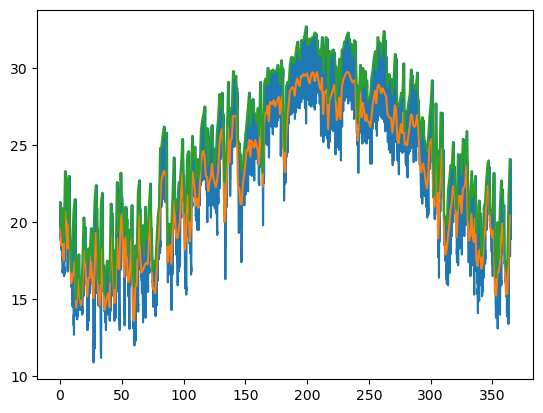

In [14]:
x_n = np.array(range(8760))/24
x_d = np.array(range(365))
y1 = w.theta_o_h
y2 = w.theta_o_ave_d
y3 = w.theta_o_max_d

# グラフの描画
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_n, y1)
ax.plot(x_d, y2)
ax.plot(x_d, y3)
plt.show()

In [ ]:
print(np.fft.fft(w.theta_o_ave_d))


[ 8.29794167e+03+0.00000000e+00j -9.35166933e+02+5.82480141e+02j
 -5.36951799e+01-1.13021384e+01j  2.90167890e+01+2.00128417e+01j
  5.96871954e+01-4.05156047e+01j -1.11256404e+01+6.47932145e+01j
  1.11828432e+01-6.98523068e+00j -1.13842472e+01-2.65176990e-01j
  2.87710778e+01-6.12757375e+00j  5.44153022e+01-3.96690831e+01j
 -1.01719491e+01-3.13434242e+01j  3.57058720e+01+9.53936559e+00j
 -5.86449685e+01+7.16518677e+01j  4.40145112e+01-2.87968212e+01j
  1.90719337e+01-2.93467691e+01j -1.46650008e+01-1.11814745e+01j
  4.58566068e+00-8.04870018e+01j  5.99612615e+01-7.78588147e+01j
  2.17327802e+01-3.57319837e+01j  3.23776030e+01-3.85722903e+01j
 -4.17538669e+01+3.28361720e+01j  3.90028647e+01+4.75868195e+01j
  2.07825999e+01-2.83729533e+01j  3.98085991e+01-1.60878651e+01j
 -3.87795514e+01-2.42818361e+01j -2.57559639e+01+7.71505307e+01j
  1.41185341e+00+1.79812398e+01j -2.59991666e+01-4.82599138e+01j
 -1.52491789e+01+1.41022219e+01j -3.56769501e+01-1.06116313e+01j
 -4.29685868e+01+6.354208

In [30]:
n_samples = 365
sample_freq = 1
frequencies = np.fft.fftfreq(n_samples, d=sample_freq)
print(frequencies)

[ 0.          0.00273973  0.00547945  0.00821918  0.0109589   0.01369863
  0.01643836  0.01917808  0.02191781  0.02465753  0.02739726  0.03013699
  0.03287671  0.03561644  0.03835616  0.04109589  0.04383562  0.04657534
  0.04931507  0.05205479  0.05479452  0.05753425  0.06027397  0.0630137
  0.06575342  0.06849315  0.07123288  0.0739726   0.07671233  0.07945205
  0.08219178  0.08493151  0.08767123  0.09041096  0.09315068  0.09589041
  0.09863014  0.10136986  0.10410959  0.10684932  0.10958904  0.11232877
  0.11506849  0.11780822  0.12054795  0.12328767  0.1260274   0.12876712
  0.13150685  0.13424658  0.1369863   0.13972603  0.14246575  0.14520548
  0.14794521  0.15068493  0.15342466  0.15616438  0.15890411  0.16164384
  0.16438356  0.16712329  0.16986301  0.17260274  0.17534247  0.17808219
  0.18082192  0.18356164  0.18630137  0.1890411   0.19178082  0.19452055
  0.19726027  0.2         0.20273973  0.20547945  0.20821918  0.2109589
  0.21369863  0.21643836  0.21917808  0.22191781  0.2

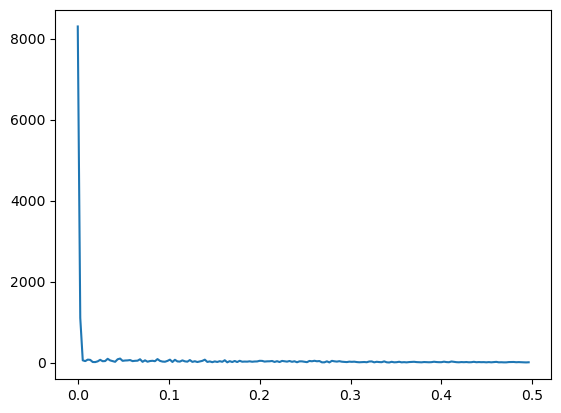

In [35]:
freq = frequencies
fft = np.abs(np.fft.fft(w.theta_o_ave_d))

# グラフの描画
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(freq[:len(freq)//2], fft[:len(freq)//2])
plt.show()